In [1]:
import pandas as pd


df = pd.read_csv("data/breast-cancer.csv")

df = df.drop(columns=["id"])
df["diagnosis"] = df["diagnosis"].map({"B": 1, "M": -1})

df["diagnosis"].value_counts()

diagnosis
 1    357
-1    212
Name: count, dtype: int64

In [2]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

X = StandardScaler().fit_transform(X)

X.shape, y.shape

((569, 30), (569,))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pydantic import BaseModel
from linear_classifier import LinearClassifier, LinearClassifierConfig


class ClassificationScores(BaseModel):
    accuracy: float
    f1: float
    precision: float
    recall: float


def evaluate_classifier(classifier: LinearClassifier) -> ClassificationScores:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return ClassificationScores(
        accuracy=accuracy_score(y_test, y_pred),
        f1=f1_score(y_test, y_pred),
        precision=precision_score(y_test, y_pred),
        recall=recall_score(y_test, y_pred),
    )

In [5]:
from IPython.display import Markdown, display


configs = [
    ("Default (Correlation)", LinearClassifierConfig(initialization="correlation")),
    (
        "Random Init",
        LinearClassifierConfig(initialization="random", random_init_std=0.1),
    ),
    ("High LR & Momentum", LinearClassifierConfig(learning_rate=0.1, momentum=0.95)),
    ("High Regularization", LinearClassifierConfig(reg_coefficient=0.1)),
    ("Margin Sampling", LinearClassifierConfig(sample_by_margin=True)),
    ("Fastest Descent", LinearClassifierConfig(fastest_descent=True)),
    ("Large Batch Size", LinearClassifierConfig(batch_size=64)),
]

results = []
for name, config in configs:
    classifier = LinearClassifier(config)
    scores = evaluate_classifier(classifier)
    results.append(
        {
            "Settings": name,
            "Accuracy": f"{scores.accuracy:.4f}",
            "F1": f"{scores.f1:.4f}",
            "Precision": f"{scores.precision:.4f}",
            "Recall": f"{scores.recall:.4f}",
        }
    )

md_table = "| Settings | Accuracy | F1 | Precision | Recall |\n"
md_table += "|-----------|-----------|----|-----------|---------|\n"
for r in results:
    md_table += f"| {r['Settings']} | {r['Accuracy']} | {r['F1']} | {r['Precision']} | {r['Recall']} |\n"

display(Markdown(md_table))
print(md_table)

| Settings | Accuracy | F1 | Precision | Recall |
|-----------|-----------|----|-----------|---------|
| Default (Correlation) | 0.9737 | 0.9790 | 0.9722 | 0.9859 |
| Random Init | 0.9737 | 0.9790 | 0.9722 | 0.9859 |
| High LR & Momentum | 0.9737 | 0.9790 | 0.9722 | 0.9859 |
| High Regularization | 0.9825 | 0.9859 | 0.9859 | 0.9859 |
| Margin Sampling | 0.9825 | 0.9859 | 0.9859 | 0.9859 |
| Fastest Descent | 0.9737 | 0.9790 | 0.9722 | 0.9859 |
| Large Batch Size | 0.9737 | 0.9790 | 0.9722 | 0.9859 |


| Settings | Accuracy | F1 | Precision | Recall |
|-----------|-----------|----|-----------|---------|
| Default (Correlation) | 0.9737 | 0.9790 | 0.9722 | 0.9859 |
| Random Init | 0.9737 | 0.9790 | 0.9722 | 0.9859 |
| High LR & Momentum | 0.9737 | 0.9790 | 0.9722 | 0.9859 |
| High Regularization | 0.9825 | 0.9859 | 0.9859 | 0.9859 |
| Margin Sampling | 0.9825 | 0.9859 | 0.9859 | 0.9859 |
| Fastest Descent | 0.9737 | 0.9790 | 0.9722 | 0.9859 |
| Large Batch Size | 0.9737 | 0.9790 | 0.9722 | 0.9859 |



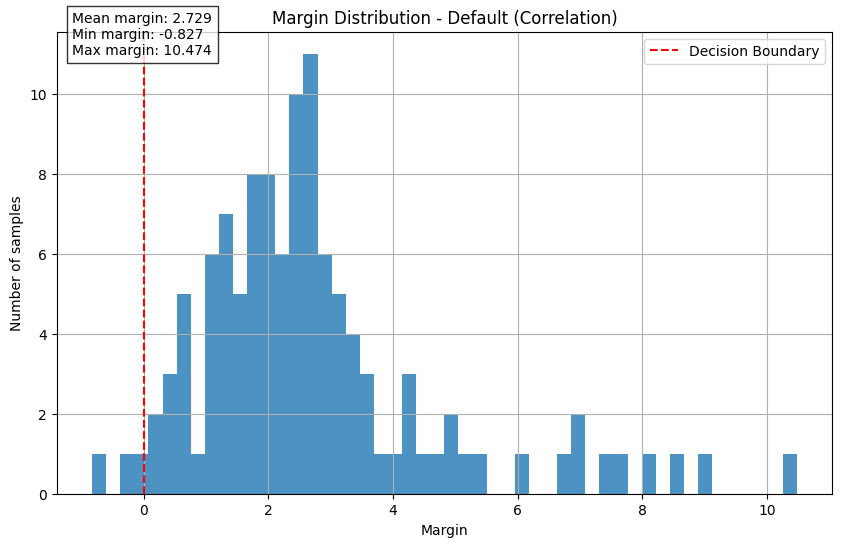

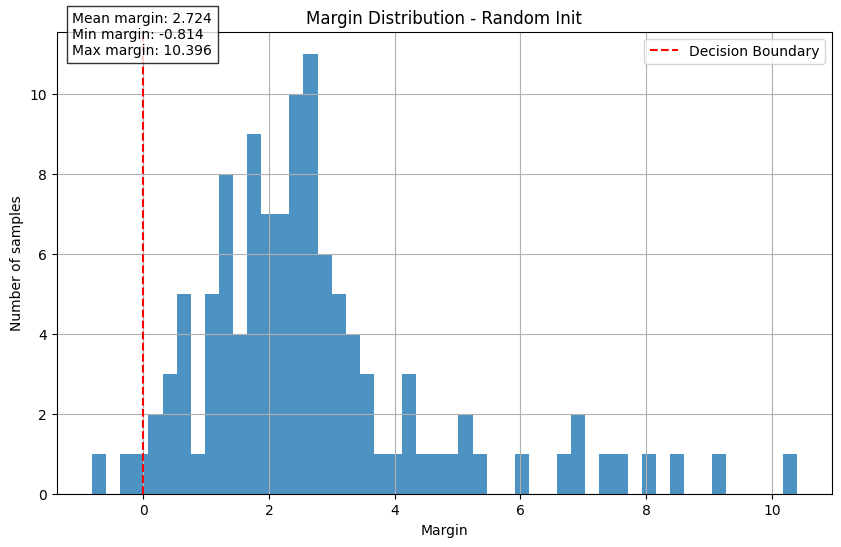

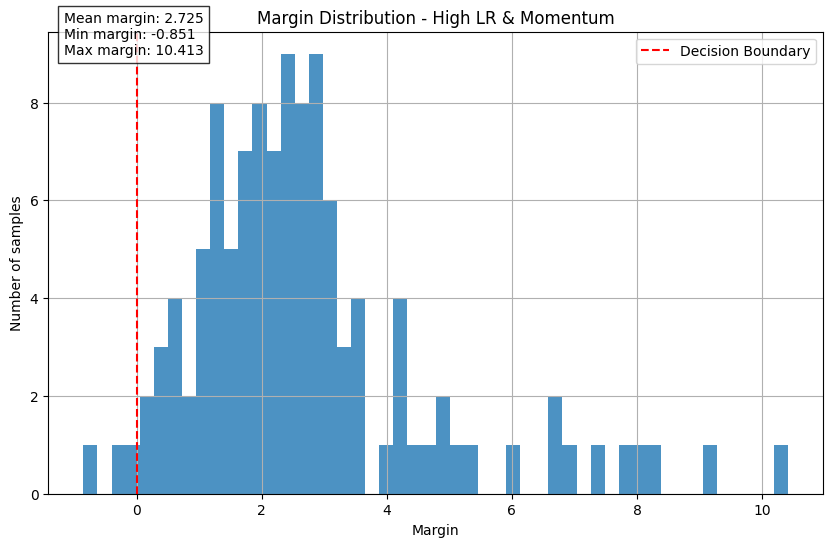

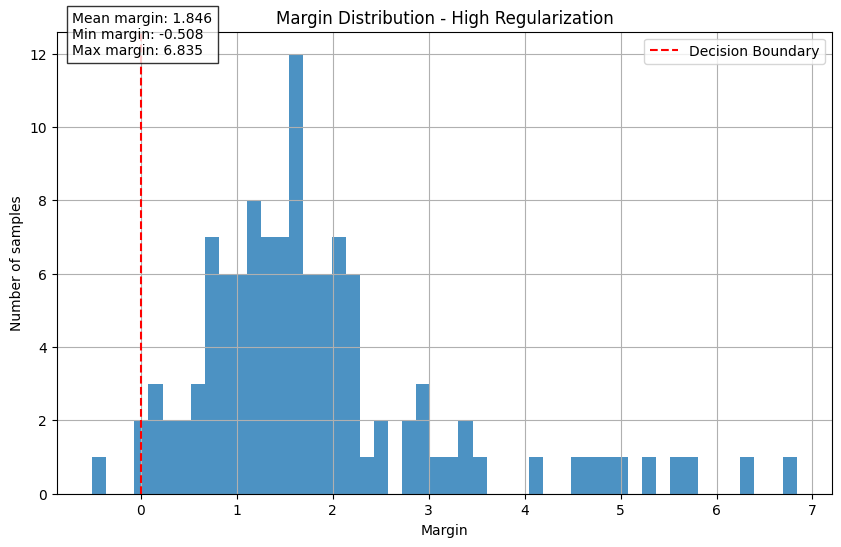

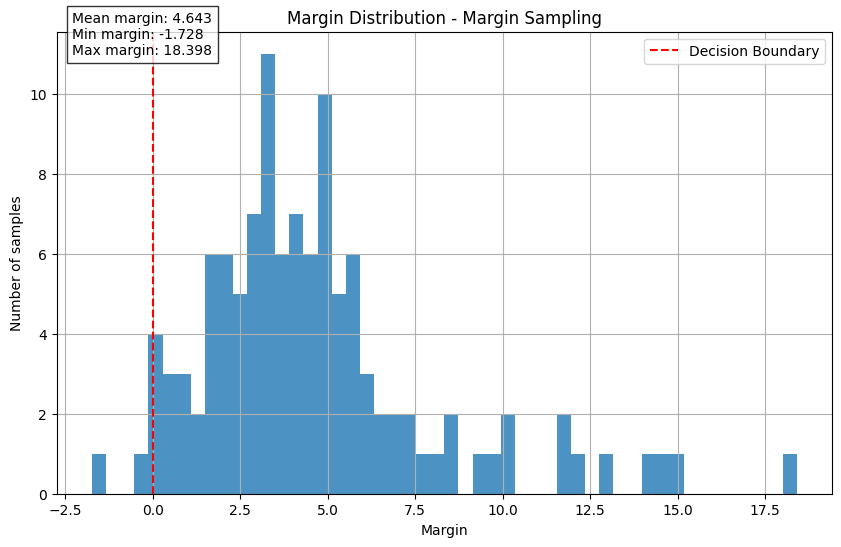

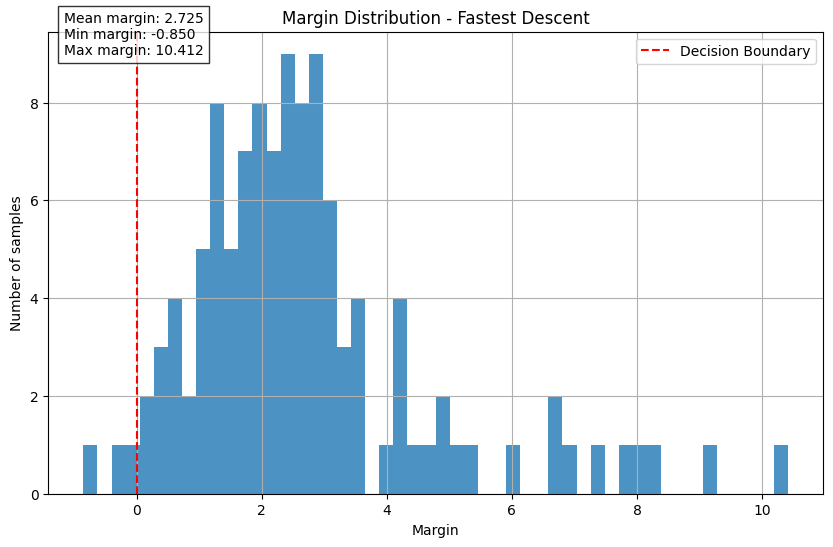

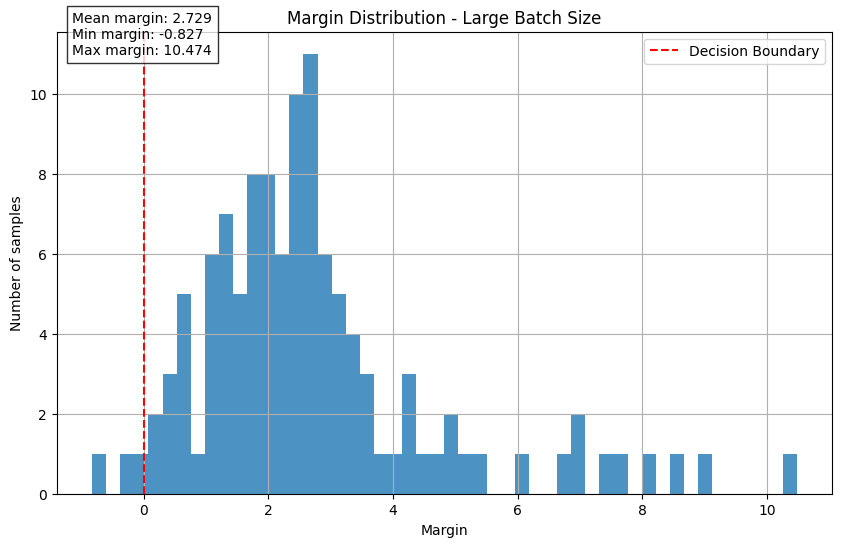

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def visualize_margins(
    classifier: LinearClassifier,
    X: np.ndarray,
    y: np.ndarray,
    title: str = "Margin Distribution",
):
    # Получаем отступы для всех объектов
    margins = classifier._margin(X, y)

    # Создаем гистограмму
    plt.figure(figsize=(10, 6))
    plt.hist(margins, bins=50, alpha=0.8)
    plt.axvline(x=0, color="r", linestyle="--", label="Decision Boundary")
    plt.xlabel("Margin")
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Добавляем статистику
    plt.text(
        0.02,
        0.95,
        f"Mean margin: {np.mean(margins):.3f}\n"
        f"Min margin: {np.min(margins):.3f}\n"
        f"Max margin: {np.max(margins):.3f}",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.8),
    )
    plt.show()


# Визуализируем отступы для каждой конфигурации
for name, config in configs:
    classifier = LinearClassifier(config)
    classifier.fit(X_train, y_train)
    visualize_margins(classifier, X_test, y_test, f"Margin Distribution - {name}")